<a href="https://colab.research.google.com/github/yfb2022/STAT_DL_INTRO/blob/main/6_3_advanced_usage_of_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
lmport keras
keras.__version__

'2.15.0'

# Advanced usage of recurrent neural networks

반복 드롭아웃 (Recurrent dropout)은 반복 레이어의 과적합을 방지하기 위해 드롭아웃을 사용하는 방법.

순환 레이어를 쌓아서 네트워크의 표현력 up(계산 부하가 높아짐).

B-D-rectonal 동일한 정보를 반복면서 네트워크에 다양한 방식으로 제공하여 정확도를 높이고 망각 문제를 완화,

## A temperature forecasting problem

Max-Planck-Institute for Biogeochemistry의 기상 관측소에서 기록된 기상 시계열 데이터 세트

이를 사용하여 최근 과거의 일부 데이터(며칠 분량의 데이터 포인트)를 입력으로 사용하고 향후 24시간 기온을 예측하는 모델을 구축할 것입니다.

Let's take a look at the data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o /content/drive/MyDrive/mpi_roof.zip

Archive:  /content/drive/MyDrive/mpi_roof.zip
  inflating: mpi_roof.csv            


In [ ]:
import os

fname = '/content/mpi_roof.csv'

f = open(fname, encoding= 'latin-1')
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"', '"rain (mm)"', '"raining (s)"', '"SWDR (W/m²)"', '"PAR (µmol/m²/s)"', '"max. PAR (µmol/m²/s)"', '"Tlog (degC)"', '"CO2 (ppm)"']
24125


Let's convert all of these 420,551 lines of data into a Numpy array:

In [25]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines[:-1]):
    values = [float(x) for x in line.split(',')[1:]]
    #print(values)
    float_data[i, :] = values

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[972.97, 14.24, 289.65, 1.78, 42.73, 16.26, 6.95, 9.31, 4.45, 7.14, 1176.2, 5.2, 9.16, 215.0, 0.0, 0.0, 4.87, 16.37, 24.49, 23.12, 425.0]
[972.93, 14.26, 289.67, 0.53, 38.99, 16.28, 6.35, 9.93, 4.07, 6.52, 1176.35, 5.33, 9.68, 219.8, 0.0, 0.0, 1.87, 8.61, 10.39, 22.91, 425.8]
[972.94, 14.0, 289.41, 0.17, 38.63, 16.01, 6.18, 9.82, 3.96, 6.36, 1177.5, 3.95, 6.74, 231.4, 0.0, 0.0, 0.0, 4.32, 6.61, 22.67, 426.3]
[972.83, 13.72, 289.14, 0.18, 39.36, 15.72, 6.19, 9.53, 3.97, 6.36, 1178.52, 2.43, 4.35, 223.5, 0.0, 0.0, 0.0, 1.22, 2.24, 22.44, 427.1]
[973.0, 13.49, 288.89, 0.16, 39.9, 15.49, 6.18, 9.31, 3.96, 6.35, 1179.67, 3.29, 6.62, 220.2, 0.0, 0.0, 0.0, 0.0, 0.0, 22.22, 427.5]
[973.07, 13.4, 288.8, 0.29, 40.53, 15.4, 6.24, 9.16, 4.0, 6.41, 1180.1, 3.03, 5.12, 217.9, 0.0, 0.0, 0.0, 0.0, 0.0, 22.01, 427.8]
[973.34, 13.38, 288.75, 0.57, 41.41, 15.38, 6.37, 9.01, 4.08, 6.54, 1180.45, 4.21, 6.75, 228.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.84, 428.1]
[975.17, 11.03, 2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



For instance, here is the plot of temperature (in degrees Celsius) over time:

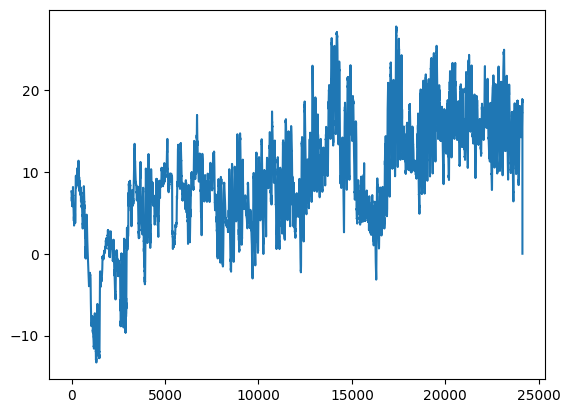

In [26]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points
per day):

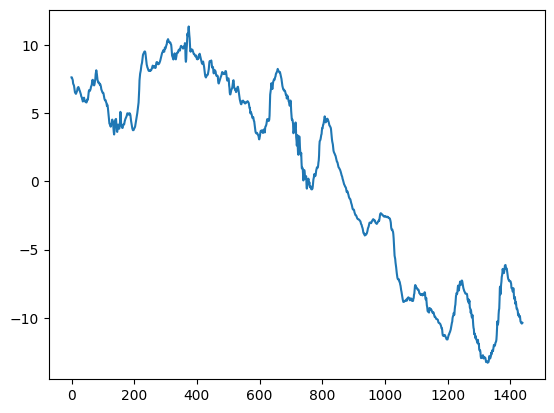

In [27]:
plt.plot(range(1440), temp[:1440])
plt.show()


On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be
coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the
reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is
this timeseries predictable at a daily scale? Let's find out.

## Preparing the data

 lookback시간 단계(시간 단계는 10분)만큼 거슬러 올라가고 모든 steps에서 샘플링된 데이터가 주어지면 delay에서 온도를 예측할 수 있습니까

다음 매개변수 값을 사용합니다.

* lookback = 1440
즉, 우리의 관찰은 10일 전으로 거슬러 올라갑니다.
* steps = 6
즉, 우리의 관찰은 시간당 하나의 데이터 포인트로 샘플링됩니다.
* delay = 144
즉, 우리의 목표는 미래 24시간이 될 것입니다.


각 시계열이 비슷한 척도에서 작은 값을 갖도록 독립적으로 정규화.

부동 소수점 데이터의 현재 배열을 가져와서 미래의 타겟 온도와 함께 최근 과거의 데이터 배치를 생성하는 생성기 함수

 데이터 세트의 샘플은 매우 중복되기 때문에(샘플 N 과 샘플 N + 1은 대부분의 time-step 공통으로 가짐) 모든 샘플을 명시적으로 할당하는 것은 낭비입니다. 대신 원본 데이터를 사용하여 즉시 샘플을 생성합니다.


In [28]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

데이터 생성 (samples, targets)에서 samples이 입력 데이터의 한 배치이고 targets는 해당 타겟 온도 배열

data– 정규화한 부동 소수점 데이터의 원래 배열.

lookback– 입력 데이터가 몇 단계 뒤로 이동해야 하는지

delay– 목표는 미래에 몇 개의 시간 단계를 거쳐야 하는지

min_index그리고 max_index– data에서 가져올 시간 단계를 구분하는 배열의 인덱스입니다. 이는 검증용 데이터 세그먼트와 테스트용 데이터 세그먼트를 유지하는 데 유용.

shuffle– 샘플을 섞을 것인지, 아니면 시간순으로 추첨할 것인지.

batch_size– 배치당 샘플 수.

step– 데이터를 샘플링하는 기간(시간 단계)입니다. 매시간 하나의 데이터 포인트를 그리려면 6으로 설정합니다.

In [29]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

추상 generator함수를 사용하여 세 개의 생성기(훈련용, 검증용, 테스트용)를 인스턴스화.

각각은 원본 데이터의 서로 다른 시간적 세그먼트를 살펴봅니다. 훈련 생성기는 처음 200,000개의 시간 단계를 살펴보고, 검증 생성기는 다음 100,000개의 시간 단계를 살펴보고, 테스트 생성기는 나머지를 살펴봅니다.

In [33]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=12000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=12001,
                    max_index=15000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=15000,
                     max_index=24125,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline

우리의 경우 온도 시계열은 연속적(내일 온도가 오늘 온도에 가까울 가능성이 높음)일 뿐만 아니라 일일 주기를 포함하는 주기적이라고 안전하게 가정할 수 있습니다. 따라서 상식적인 접근 방식은 지금으로부터 24시간 후의 기온이 현재 기온과 같을 것이라고 항상 예측하는 것입니다. MAE(평균 절대 오류) 지표를 사용하여 이 접근 방식을 평가해 보겠습니다. 평균 절대 오류는 다음과 같습니다.

In [31]:
np.mean(np.abs(preds - targets))

NameError: name 'preds' is not defined

Here's our evaluation loop:

In [34]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.5033113862493603


It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this
number is not immediately interpretable. It translates to an average absolute error of `0.29 * temperature_std` degrees Celsius, i.e.
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better.

## A basic machine learning approach

데이터를 평면화하여 시작한 다음 두 개의 Dense 레이어를 통해 실행하는 모델

회귀 문제에서 일반적으로 나타나는 마지막 밀집 레이어에는 활성화 함수가 없다는 점에 유의하세요

MAE를 손실로 사용합니다.

In [35]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
# input_shape = c(lookback / step, dim(data)[-1])
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

<ipython-input-35-3b10b6cf27c5>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 19s 37ms/step - loss: 0.1978 - val_loss: 2.1998
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0881 - val_loss: 2.0394
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.0750 - val_loss: 1.9727
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.0682 - val_loss: 1.9529
Epoch 5/20
500/500 [==============================] - 34s 69ms/step - loss: 0.0630 - val_loss: 1.9294
Epoch 6/20
500/500 [==============================] - 23s 46ms/step - loss: 0.0604 - val_loss: 1.9478
Epoch 7/20
500/500 [==============================] - 33s 66ms/step - loss: 0.0583 - val_loss: 1.9617
Epoch 8/20
500/500 [==============================] - 27s 54ms/step - loss: 0.0565 - val_loss: 1.9706
Epoch 9/20
500/500 [==============================] - 30s 60ms/step - loss: 0.0553 - val_loss: 1.9643
Epoch 10/20
500/500 [==============================] - 24s 47ms/step - loss: 0.054

Let's display the loss curves for validation and training:

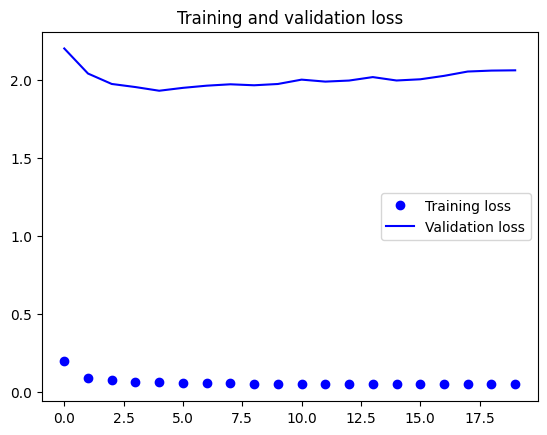

In [36]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our
common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline

위의 접근 방식은 먼저 시계열을 평면화하여 입력 데이터에서 시간 개념을 제거하는 것으로 구성.

대신 데이터를 있는 그대로, 즉 인과성과 순서가 중요한 시퀀스로 살펴보겠습니다. 우리는 순환 시퀀스 처리 모델을 시도할 것입니다. 이는 첫 번째 접근 방식과 달리 데이터 포인트의 시간적 순서를 활용하기 때문에 이러한 시퀀스 데이터에 완벽하게 적합해야 합니다.

이전 섹션에서 소개한 LSTM 레이어 대신 Cho 등이 개발한 GRU 레이어를 사용하겠습니다. GRU 레이어(“Gated Recurrent Unit”의 약어)는 LSTM과 동일한 원리를 활용하여 작동하지만 LSTM만큼 표현력이 부족하더라도 다소 간소화되어 실행 비용이 저렴합니다. 계산 비용과 표현 능력 사이의 이러한 균형은 기계 학습의 모든 곳에서 볼 수 있습니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


<ipython-input-37-3729ba6f581e>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 144s 284ms/step - loss: 0.2930 - val_loss: 1.0758
Epoch 2/20
500/500 [==============================] - 131s 262ms/step - loss: 0.1972 - val_loss: 1.2226
Epoch 3/20
500/500 [==============================] - 161s 322ms/step - loss: 0.1545 - val_loss: 1.2368
Epoch 4/20
500/500 [==============================] - 125s 250ms/step - loss: 0.1247 - val_loss: 1.3378
Epoch 5/20
500/500 [==============================] - 133s 267ms/step - loss: 0.1063 - val_loss: 1.2855
Epoch 6/20
500/500 [==============================] - 120s 241ms/step - loss: 0.0946 - val_loss: 1.2831
Epoch 7/20
500/500 [==============================] - 147s 295ms/step - loss: 0.0861 - val_loss: 1.2541
Epoch 8/20
384/500 [======================>.......] - ETA: 19s - loss: 0.0808

Let look at our results:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after
de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting

훈련 및 검증 곡선을 보면 우리 모델이 과적합되고 있음이 분명합니다. 훈련 및 검증 손실은 몇 에포크 후에 상당히 분기되기 시작합니다. 이는 레이어가 노출되는 훈련 데이터에서 우연한 상관관계를 깨기 위해 레이어의 입력 단위를 무작위로 0으로 만드는 것으로 구성됩니다.

순환 레이어 이전에 드롭아웃을 적용하면 정규화에 도움이 되기보다는 학습을 방해한다는 것이 오랫동안 알려져 왔습니다.

시간 단계마다 무작위로 달라지는 드롭아웃 마스크 대신 동일한 드롭아웃 마스크(동일한 드롭아웃 유닛 패턴)를 모든 단계에 적용해야 합니다.

게다가 GRU 및 LSTM과 같은 레이어의 반복 게이트에 의해 형성된 표현을 정규화하려면 시간적으로 일정한 드롭아웃 마스크가 레이어의 내부 반복 활성화("반복" 드롭아웃 마스크)에 적용되어야 합니다. 모든 단계에서 동일한 드롭아웃 마스크를 사용하면 네트워크가 시간에 따라 학습 오류를 적절하게 전파할 수 있습니다. 일시적으로 무작위인 드롭아웃 마스크는 대신 이 오류 신호를 방해하고 학습 프로세스에 해로울 수 있습니다.

드롭아웃으로 정규화된 네트워크는 완전히 수렴하는 데 항상 더 오랜 시간이 걸리기 때문에 네트워크를 두 배의 에포크 동안 훈련합니다.


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best
scores are not much lower than they were previously.

## Stacking recurrent layers

더 이상 과적합 상태가 아니지만 성능 병목 현상에 직면한 것 같으므로 네트워크 용량 증가를 고려해야 합니다.

"보편적 기계 학습 작업 흐름"에 대한 설명을 기억하신다면 일반적으로 과적합이 주요 장애물이 될 때까지 네트워크 용량을 늘리는 것이 좋습니다

네트워크 용량을 늘리려면 일반적으로 레이어의 장치 수를 늘리거나 레이어를 추가하면 됩니다. 순환 레이어 스태킹은 보다 강력한 순환 네트워크를 구축하는 고전적인 방법입니다.

Keras에서 순환 레이어를 서로 쌓으려면 모든 중간 레이어가 마지막 시간 단계의 출력이 아닌 전체 출력 시퀀스(3D 텐서)를 반환해야 합니다. 이는 다음을 지정하여 수행됩니다 return_sequences = TRUE.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Let's take a look at our results:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

* 아직 너무 심하게 과적합되지는 않았으므로 검증 손실을 약간 개선하기 위해 레이어 크기를 안전하게 늘릴 수 있습니다. 하지만 이는 무시할 수 없는 계산 비용을 발생시킵니다.

* 레이어를 추가해도 큰 도움이 되지 않았기 때문에 이 시점에서는 네트워크 용량 증가에 따른 수익이 감소하는 것을 볼 수 있습니다.

## Using bidirectional RNNs

양방향 RNN은 특정 작업에서 일반 RNN보다 더 높은 성능을 제공할 수 있는 일반적인 RNN 변형입니다. 이는 자연어 처리에 자주 사용됩니다. NLP를 위한 딥 러닝의 스위스 군용 칼이라고 부를 수 있습니다.

RNN은 특히 순서 의존적이거나 시간 의존적입니다. 시간 단계를 섞거나 반전하면 RNN이 시퀀스에서 추출할 표현이 완전히 변경될 수 있습니다.

양방향 RNN은 RNN의 순서 민감성을 활용합니다. 이는 이미 익숙한 GRU 또는 LSTM 레이어와 같은 두 개의 일반 RNN으로 구성되며, 각 RNN은 입력 시퀀스를 한 방향(연대순 및 반연대순)으로 처리한 다음 표현을 병합합니다.양방향 RNN은 시퀀스를 양방향으로 처리함으로써 단방향 RNN에서 간과할 수 있는 패턴을 포착할 수 있습니다.

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=18000,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=18001,
    max_index=24125,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

따라서 역순 GRU는 상식적인 기준보다 성능이 훨씬 낮습니다. 이는 우리의 경우 연대순 처리*가 접근 방식의 성공에 매우 중요하다는 것을 나타냅니다. 이것은 완벽하게 이해됩니다. 기본 GRU 레이어는 일반적으로 먼 과거보다 최근 과거를 더 잘 기억하며 당연히 더 최근의 날씨 데이터 포인트는 문제의 이전 데이터 포인트보다 더 예측 가능합니다. 상당히 강력한 기준선). 따라서 레이어의 연대순 버전은 역순 버전보다 성능이 뛰어납니다. 중요한 것은 자연어*를 포함한 다른 많은 문제에서는 일반적으로 그렇지 않다는 것입니다. 직관적으로 문장을 이해하는 데 있어 단어의 중요성*은 일반적으로 문장에서의 위치에 의존하지 않습니다. 이전 섹션의 LSTM IMDB 예제에서 동일한 트릭을 시도해 보겠습니다

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
# x_train <- lapply(x_train, rev)
# x_test <- lapply(x_test, rev)

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


이전 섹션에서 시도한 시간순 LSTM과 거의 동일한 성능을 얻었습니다.

따라서 놀랍게도 이러한 텍스트 데이터 세트에서 역순 처리는 시간순 처리와 마찬가지로 작동하여 언어를 이해하는 데 단어 순서가 중요 하지만 사용하는 순서는 중요하지 않다는 가설 을 확인합니다.

중요한 것은 역방향 시퀀스에 대해 훈련된 RNN은 원래 시퀀스에 대해 훈련된 RNN과 다른 표현을 학습한다는 것입니다.

양방향 RNN은 이 아이디어를 활용하여 연대순 RNN의 성능을 향상시킵니다. 입력 시퀀스를 양방향으로 살펴보고 잠재적으로 더 풍부한 표현을 얻고 연대순 버전만으로는 놓칠 수 있는 패턴을 캡처합니다.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

양방향 RNN

Keras에서 양방향 RNN을 인스턴스화하려면 bidirectional()를 사용합니다. 함수 bidirectional()는 이 순환 레이어의 별도의 두 번째 인스턴스를 생성하고 한 인스턴스를 사용하여 입력 시퀀스를 시간순으로 처리하고 다른 인스턴스를 사용하여 입력 시퀀스를 역순으로 처리합니다. IMDB 감정 분석 작업에서 시도해 보겠습니다.

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)



이전 섹션에서 시도한 일반 LSTM보다 약간 더 나은 성능을 발휘하며 검증 정확도가 88% 이상입니다. 또한 양방향 레이어가 시간순 LSTM보다 두 배 더 많은 매개변수를 갖고 있기 때문에 더 빠르게 과적합되는 것처럼 보입니다. 이는 놀라운 일이 아닙니다. 일부 정규화를 통해 양방향 접근 방식이 이 작업에서 강력한 성능을 발휘할 가능성이 높습니다.

이제 날씨 예측 작업에 대해 동일한 접근 방식을 시도해 보겠습니다.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

일반 GRU 계층과 거의 비슷한 성능을 발휘합니다. 이유를 이해하는 것은 쉽습니다. 모든 예측 능력은 네트워크의 연대기적 절반에서 나와야 합니다. 왜냐하면 연대기적 절반은 이 작업에서 심각하게 저조한 성능을 보이는 것으로 알려져 있기 때문입니다(다시 말하지만 최근 과거가 먼 과거보다 훨씬 더 중요하기 때문입니다).


## Going even further

일기 예보 문제의 성능을 향상시키기 위해 시도해 볼 수 있는 다른 방법이 많이 있습니다.

* 스택 설정에서 각 반복 레이어의 단위 수를 조정합니다. 현재 선택은 대체로 임의적이므로 차선책일 수 있습니다.

* 옵티마이저가 사용하는 학습률을 조정합니다

* layer_lstm()대신 사용해 보세요 layer_gru().

* 순환 레이어 위에 더 큰 밀도로 연결된 회귀 분석기를 사용해 보세요. 즉, 더 큰 밀도 레이어 또는 밀도 레이어 스택을 사용해 보세요.

* 테스트 세트에서 (검증 MAE 측면에서) 최고 성능의 모델을 실행하는 것을 잊지 마세요! 그렇지 않으면

## Wrapping up

* 4장에서 처음 배운 것처럼, 새로운 문제에 접근할 때 먼저 선택한 측정항목에 대한 상식적인 기준을 설정하는 것이 좋습니다. 이길 수 있는 기준선이 없으면 실제적인 진전이 있는지 알 수 없습니다.

* 추가 비용을 정당화하기 위해 값비싼 모델보다 간단한 모델을 시도해 보십시오. 때로는 단순한 모델이 최선의 선택이 될 수도 있습니다.

* 시간적 순서가 중요한 데이터가 있는 경우 순환 네트워크는 매우 적합하며 시간적 데이터를 먼저 평면화하는 모델보다 쉽게 ​​성능이 뛰어납니다.

* 순환 신경망에서 드롭아웃을 사용하려면 시간 상수 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 합니다. 이는 Keras 반복 레이어에 내장되어 있으므로 반복 레이어의 dropout및 인수를 사용하기만 하면 됩니다 recurrent_dropout.

* 스택형 RNN은 단일 RNN 레이어보다 더 많은 표현력을 제공합니다. 또한 훨씬 더 비싸기 때문에 항상 그만한 가치가 있는 것은 아닙니다. 복잡한 문제(예: 기계 번역)에 대해 명확한 이점을 제공하지만 더 작고 단순한 문제와 항상 관련이 있는 것은 아닙니다.

* 시퀀스를 양방향으로 보는 양방향 RNN은 자연어 처리 문제에 유용합니다. 그러나 최근 과거가 시퀀스 시작보다 훨씬 더 많은 정보를 제공하는 시퀀스 데이터에서는 강력한 성능을 발휘하지 못합니다.
